In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy import stats
import yaml
from astropy.coordinates import SkyCoord

from gammapy.data import DataStore
from regions import CircleSkyRegion
from gammapy.modeling import Fit
from gammapy.datasets import MapDataset
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling.models import Models, Model, SkyModel, FoVBackgroundModel
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.modeling import Fit, Parameter, Parameters, Covariance


import warnings
from my_dataset_maps_19 import MapDatasetNuisance
warnings.filterwarnings('ignore')
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']



In [2]:
def plot_residual_comparison(dataset1, dataset2, elist, radius = 1.0, ):
    print("Radius:", radius)
    fig, axs = plt.subplots(len(elist)*1,3 ,figsize =(15,len(elist)*5))
    if len(elist) ==1:
        axs = [axs]
    for i , e in enumerate (elist):
        print(e)
        residual1 = dataset1.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1))).smooth(radius)
        residual2 = dataset2.residuals('diff/sqrt(model)').slice_by_idx(dict(energy=slice(e,e+1))).smooth(radius)
        print("residual1.data:", np.nanmax(residual1.data))
        vmax_ = np.nanmax(np.abs(residual1.data))
        print("vmax_:", vmax_)   
        residual2.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][1],
                                                      vmax = vmax_, vmin = -vmax_)
        residual1.plot(cmap = 'coolwarm', add_cbar = True,ax = axs[i][0],
                                                        vmax = vmax_, vmin = -vmax_)
        n, bins, patches = axs[i][2].hist(residual1.data.flatten(),bins = 70,
                           label = 'Standard \n $\mu=${:.2}, $\sigma=${:.4}'.format(
                           np.nanmean(residual1.data.flatten()),
                           np.nanstd(residual1.data.flatten())),
                                  color = default_colors[1], alpha = 0.5)
        axs[i][2].hist(residual2.data.flatten(),bins = bins,
                                 label = 'Standard $\cdot (1+N) $\n $\mu=${:.2}, $\sigma=${:.4}'.format(
                               np.nanmean(residual2.data.flatten()),
                               np.nanstd(residual2.data.flatten())),
                           color = default_colors[2], alpha = 0.5)



        axs[i][2].legend()
        axs[i][2].set_xlabel('Significance'); axs[i][2].set_yscale('log')
        axs[i][1].set_title('After; Smoothing Radius:'+str(radius))
        ee = dataset1.geoms['geom'].axes[0]
        ee_start = ee.edges[e]
        ee_end = ee.edges[e+1]
        ee = f"[{ee_start.value:.2}:{ee_end.value:.2}] TeV"
        axs[i][0].set_title(ee)
        

    plt.tight_layout()
    return fig



In [3]:
source = "Crab"

In [4]:
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'
# here the dataset with the fine binning is saved
dataset_standard = MapDataset.read(f'{path}/{source}/stacked.fits')
# This is for now the binning of 0.08 deg
#dataset_standard = MapDataset.read(f'{source}/stacked.fits')

models = Models.read(f'{source}/standard_model.yml')
dataset_standard.models = models

In [5]:
path = f"{source}/"
dataset_N_10 = MapDatasetNuisance.read(path+ 'nui_dataset.fits')
with open(path+ 'nui_par.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N_10.N_parameters = Parameters.from_dict(nui_par )
with open(path+ 'nui_model.yml', "r") as ymlfile:
    best_fit_model = yaml.load(ymlfile, Loader=yaml.FullLoader)
with open(path+ 'nui_bgmodel.yml', "r") as ymlfile:
    best_fit_bgmodel = yaml.load(ymlfile, Loader=yaml.FullLoader)
bkg_model = FoVBackgroundModel(dataset_name=dataset_N_10.name)
bkg_model.parameters['norm'].value = best_fit_bgmodel['spectral']['parameters'][0]['value']
bkg_model.parameters['tilt'].value = best_fit_bgmodel['spectral']['parameters'][1]['value']
models = Models.from_dict(best_fit_model )
models.append(bkg_model)
dataset_N_10.models =models

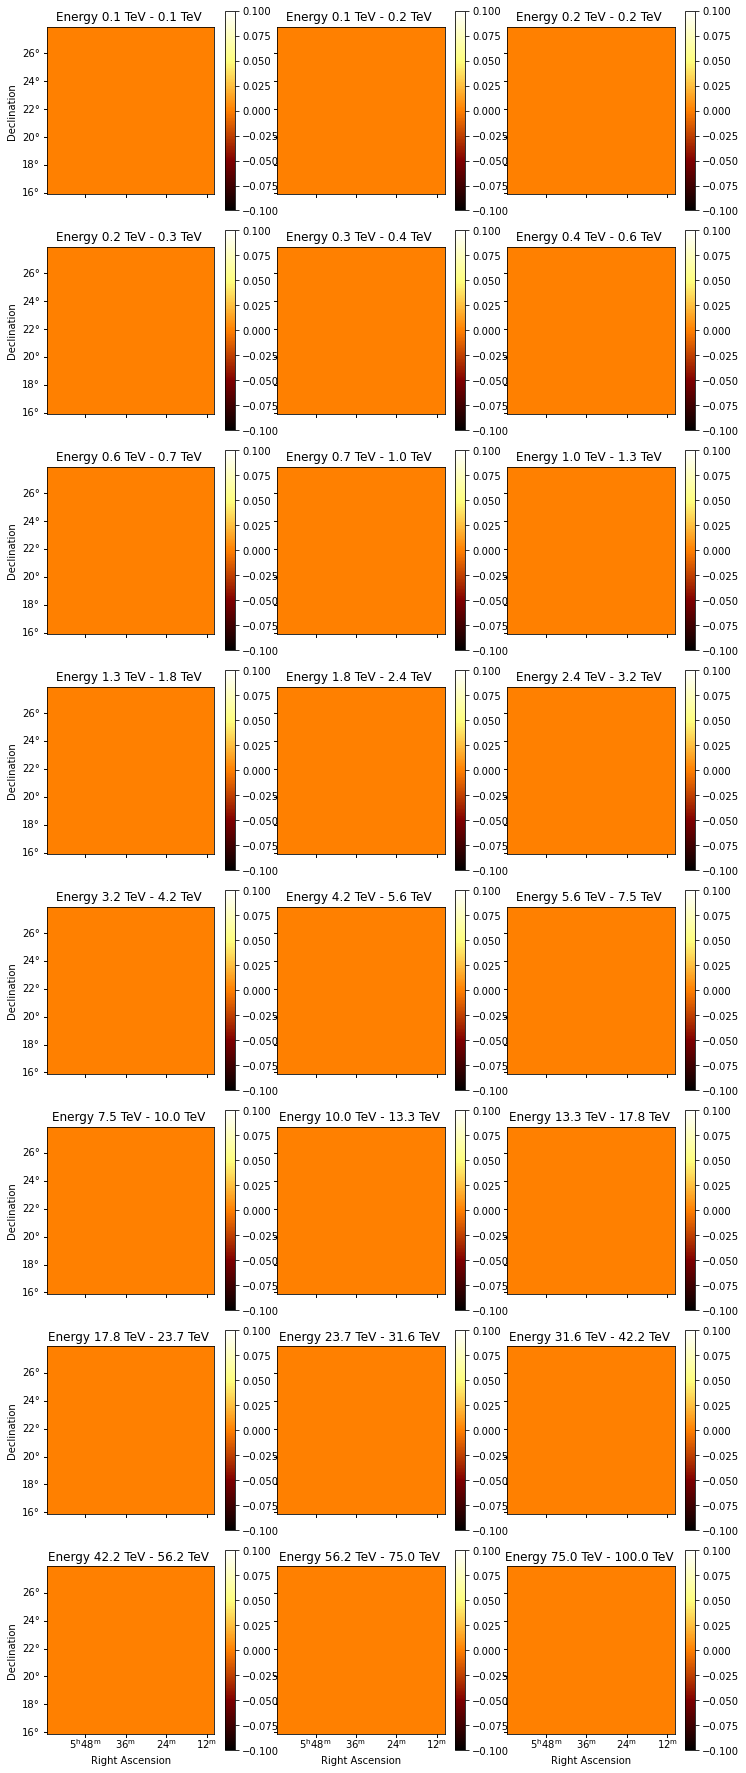

In [6]:
dataset_N_10.N_map().plot_grid(add_cbar = True);

0.3368948903574033


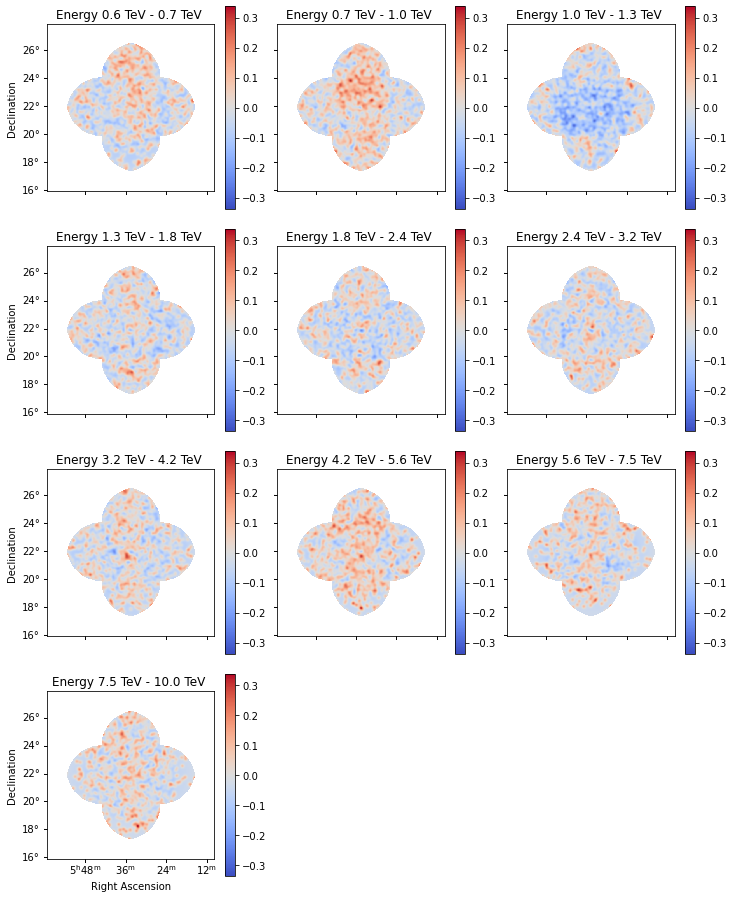

In [7]:
res_standard = (
    dataset_standard.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
vmax = np.max(np.abs(np.nan_to_num(res_standard.data)))
print(vmax)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

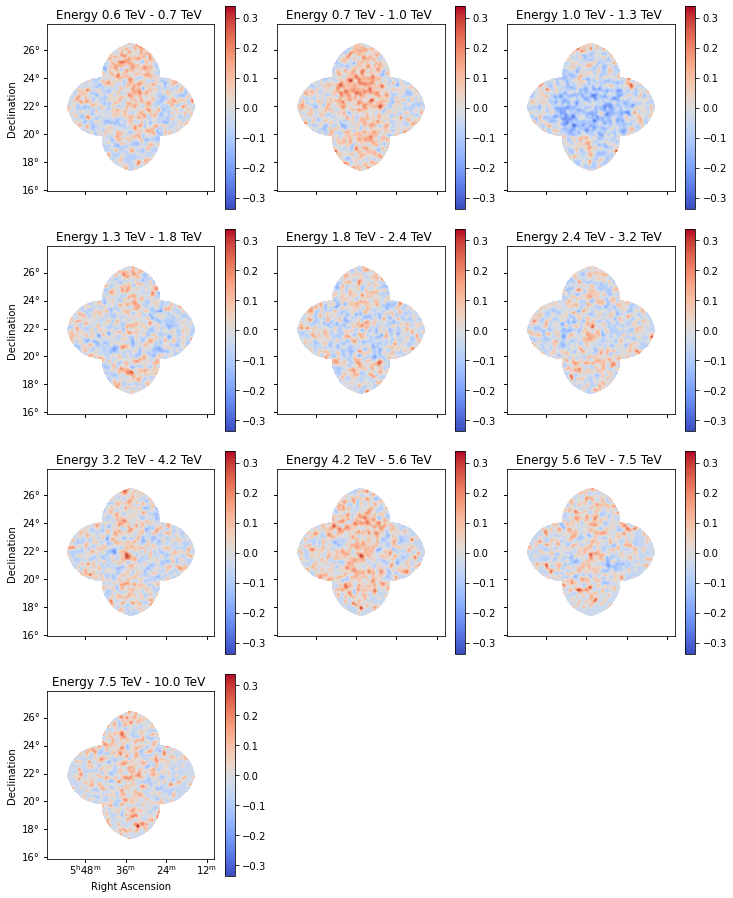

In [8]:
res_standard = (
    dataset_N_10.residuals("diff/sqrt(model)")
    .slice_by_idx(dict(energy=slice(6, 16)))
    .smooth(0.1 * u.deg)
)
res_standard.plot_grid(add_cbar=1, vmax=vmax, vmin=-vmax, cmap="coolwarm");

Radius: 0.1 deg
10
residual1.data: 0.2607364455989791
vmax_: 0.2607364455989791


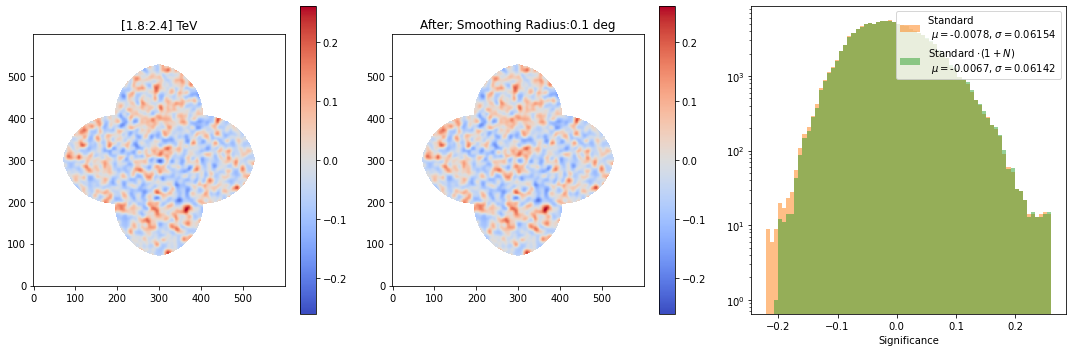

In [9]:
fig = plot_residual_comparison(dataset_standard, dataset_N_10,[10] , radius = 0.1 *u.deg)